# 1.6 Homework

The goal of this homework is to train a simple model for predicting the duration of a ride - similar to what we did in this module.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error


## Q1. Downloading the data

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page),
but instead of "Green Taxi Trip Records", we'll use "For-Hire Vehicle Trip Records".

Download the data for January and February 2021.

Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".

Read the data for January. How many records are there?

* 1054112
* 1154112
* 1254112
* 1354112

In [2]:
if not os.path.exists("data"):
    os.makedirs("data")

if not os.path.exists("data/fhv_tripdata_2021-01.parquet"):
    !wget -O data/fhv_tripdata_2021-01.parquet https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet 
if not os.path.exists("data/fhv_tripdata_2021-02.parquet"):
    !wget -O data/fhv_tripdata_2021-02.parquet https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet 

In [3]:
df_jan = pd.read_parquet("data/fhv_tripdata_2021-01.parquet")

In [4]:
print(f"[ANSWER] Length of January records is: {df_jan.shape[0]}")

[ANSWER] Length of January records is: 1154112



## Q2. Computing duration

Now let's compute the `duration` variable. It should contain the duration of a ride in minutes. 

What's the average trip duration in January?

* 15.16
* 19.16
* 24.16
* 29.16

In [5]:
df_jan.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [6]:
df_jan['duration'] = df_jan.dropOff_datetime - df_jan.pickup_datetime
df_jan.duration = df_jan.duration.apply(lambda td: td.total_seconds() / 60)

In [7]:
print(f"[ANSWER] Average trip duration in January is : {round(df_jan.duration.mean(), 3)}[min]")

[ANSWER] Average trip duration in January is : 19.167[min]


## Data preparation

Check the distribution of the duration variable. There are some outliers. 

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop? 

/home/innervycs/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


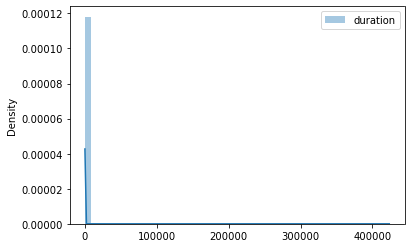

In [8]:
sns.distplot(df_jan.duration.values, label='duration')

plt.legend()

In [9]:
df_jan = df_jan[(df_jan.duration >= 1) & (df_jan.duration <= 60)]

In [10]:
print(f"[ANSWER] Were dropped {1154112 - df_jan.shape[0]} records")

[ANSWER] Were dropped 44286 records


## Q3. Missing values

The features we'll use for our model are the pickup and dropoff location IDs. 

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

* 53%
* 63%
* 73%
* 83%

In [11]:
categorical = ['PUlocationID', 'DOlocationID']
df_jan[categorical] = df_jan[categorical].fillna(-1)

In [12]:
ones = df_jan[df_jan['PUlocationID'] == -1].shape[0]
print(f"[ANSWER] The fraction of missing values for the pickup location ID is: {round(((ones+100)/df_jan.shape[0])*100,2)} ")

[ANSWER] The fraction of missing values for the pickup location ID is: 83.54 


## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

* Turn the dataframe into a list of dictionaries
* Fit a dictionary vectorizer 
* Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns).

* 2
* 152
* 352
* 525
* 725

In [13]:
df_jan[categorical] = df_jan[categorical].astype(str)

train_dicts = df_jan[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df_jan[target].values

In [14]:
print(f"[ANSWER] The dimensionality of the matrix is: {X_train.shape[1]}")


[ANSWER] The dimensionality of the matrix is: 525


## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. 

* Train a plain linear regression model with default parameters 
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

* 5.52
* 10.52
* 15.52
* 20.52

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

rmse = mean_squared_error(y_train, y_pred, squared=False) # False for rmse True for mse
print(f"[ANSWER] The RMSE is: {rmse}")

[ANSWER] The RMSE is: 10.52851910720588


## Q6. Evaluating the model

Now let's apply this model to the validation dataset (Feb 2021). 

What's the RMSE on validation?

* 6.01
* 11.01
* 16.01
* 21.01


In [16]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].fillna(-1)
    df[categorical] = df[categorical].astype(str)
    return df

df_feb = read_dataframe("data/fhv_tripdata_2021-02.parquet")

In [17]:
categorical = ['PUlocationID', 'DOlocationID']
target = 'duration'

val_dicts = df_feb[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_val = df_feb[target].values

In [18]:
y_pred = lr.predict(X_val)
rmse_val = mean_squared_error(y_val, y_pred, squared=False)

print(f"[ANSWER] The validation RMSE is: {rmse_val}")

[ANSWER] The validation RMSE is: 11.014283147710056
